# Energetic Forecast with Prophet

In [2]:
import datetime
import itertools
import pandas as pd
import numpy as np
#import pandas_profiling

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Prophet modeling libaries
from prophet import Prophet
# metrics
from random import random
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error

# Importing data
- Dataset: Electricity consumption in the state of PMJ
- Unit: Mega Watt: MW
- Hourly timestamp


<img src="https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/energy_cons.png" width="1000">

In [3]:
!wget https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/PJME_hourly.csv

--2025-01-30 05:31:45--  https://frenzy86.s3.eu-west-2.amazonaws.com/IFAO/PJME_hourly.csv
Resolving frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)... 52.95.143.14, 3.5.244.11, 3.5.244.200, ...
Connecting to frenzy86.s3.eu-west-2.amazonaws.com (frenzy86.s3.eu-west-2.amazonaws.com)|52.95.143.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4070265 (3.9M) [text/csv]
Saving to: ‘PJME_hourly.csv’

PJME_hourly.csv     100%[===================>]   3.88M  3.81MB/s    in 1.0s    

2025-01-30 05:31:47 (3.81 MB/s) - ‘PJME_hourly.csv’ saved [4070265/4070265]



In [4]:
df = pd.read_csv('PJME_hourly.csv')
df

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


## __Converting to datetime format and sort:__

In [5]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.sort_values(by=['Datetime'], axis=0, ascending=True, inplace=True)
df.rename(columns={'PJME_MW':'Consumption [MW]'}, inplace=True)
df

,Datetime,Consumption [MW]
8734,2002-01-01 01:00:00,30393.0
8735,2002-01-01 02:00:00,29265.0
8736,2002-01-01 03:00:00,28357.0
8737,2002-01-01 04:00:00,27899.0
8738,2002-01-01 05:00:00,28057.0
...,...,...
140250,2018-08-02 20:00:00,44057.0
140251,2018-08-02 21:00:00,43256.0
140252,2018-08-02 22:00:00,41552.0
140253,2018-08-02 23:00:00,38500.0


## __Removal duplicates__:

In [ ]:
#keep only the last measurement for datetime
df.drop_duplicates(subset='Datetime', keep='last', inplace=True)

## __Setting index as the datetime column for easier manipulations:__

In [6]:
df = df.set_index('Datetime')
df

,Consumption [MW]
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


__Note:__
- datetime index's frequency is None => there are some missing data points somewhere (otherwise Python could deduce it) => remove missing

## __Find and Fill Missing datetime Instances__

In [7]:
# ideal range: without missing data
date_range = pd.date_range(start=min(df.index), end=max(df.index), freq='H')

In [9]:
df = df[~df.index.duplicated(keep='first')]

# Reindex
df = df.reindex(date_range)

# Interpolate missing values
df['Consumption [MW]'].interpolate(method='linear', inplace=True)

In [10]:
df

,Consumption [MW]
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0
2018-08-02 23:00:00,38500.0


## Extracting Time Features

- We split datetime into its different __features__ => to find patterns for different groups.

In [12]:
# Create time-based features
df['dayofweek'] = df.index.dayofweek
df['dayofyear'] = df.index.dayofyear
df['year'] = df.index.year
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
# Replace weekofyear with isocalendar
df['weekofyear'] = df.index.isocalendar().week
df['dayofmonth'] = df.index.day  # Day of Month
df['date'] = df.index.date

# Add season number
df['season'] = df['month'].apply(lambda month_number: (month_number%12 + 3)//3)

In [13]:
df

,Consumption [MW],dayofweek,dayofyear,year,month,quarter,hour,weekday,weekofyear,dayofmonth,date,season
2002-01-01 01:00:00,30393.0,1,1,2002,1,1,1,1,1,1,2002-01-01,1
2002-01-01 02:00:00,29265.0,1,1,2002,1,1,2,1,1,1,2002-01-01,1
2002-01-01 03:00:00,28357.0,1,1,2002,1,1,3,1,1,1,2002-01-01,1
2002-01-01 04:00:00,27899.0,1,1,2002,1,1,4,1,1,1,2002-01-01,1
2002-01-01 05:00:00,28057.0,1,1,2002,1,1,5,1,1,1,2002-01-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,3,214,2018,8,3,20,3,31,2,2018-08-02,3
2018-08-02 21:00:00,43256.0,3,214,2018,8,3,21,3,31,2,2018-08-02,3
2018-08-02 22:00:00,41552.0,3,214,2018,8,3,22,3,31,2,2018-08-02,3
2018-08-02 23:00:00,38500.0,3,214,2018,8,3,23,3,31,2,2018-08-02,3


## Forecasting metrics


In [14]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(y_true,y_pred):
    results = pd.DataFrame({'r2_score':r2_score(y_true-np.median(y_true), y_pred-np.median(y_pred))},
                           index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y_true, y_pred)
    results['median_absolute_error'] = median_absolute_error(y_true, y_pred)
    results['mse'] = mean_squared_error(y_true, y_pred)
    results['msle'] = mean_squared_log_error(y_true, y_pred)
    results['mape'] = mean_absolute_percentage_error(y_true, y_pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

# Long Term Forecasting

## Train and Test split

In [15]:
y    = df['Consumption [MW]']
df.index.min(),df.index.max()

(Timestamp('2002-01-01 01:00:00'), Timestamp('2018-08-03 00:00:00'))

In [18]:
t_train_start = '2013-01-01'
t_train_end   = '2016-12-31'

# splitting
y_train = y.loc[(y.index >= t_train_start) & (y.index <= t_train_end)].copy()
y_test  = y.loc[(y.index >  t_train_end)].copy()
y = pd.concat([y_train, y_test])

In [19]:
y_train.index.min(), y_train.index.max(), y_test.index.min(), y_test.index.max(),

(Timestamp('2013-01-01 00:00:00'),
 Timestamp('2016-12-31 00:00:00'),
 Timestamp('2016-12-31 01:00:00'),
 Timestamp('2018-08-03 00:00:00'))

In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_train.index, y=y_train,
                         mode='lines',
                         name='Train'))

fig.add_trace(go.Scatter(x=y_test.index, y=y_test,
                         mode='lines',
                         name='Test'))

# adjust layout
fig.update_layout(title='Train/Test Split',
                  xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='Energy Demand [MW]')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

## The Prophet Forecasting Model

Prophet was developed by Facebook and released as open source in 2017: [https://facebook.github.io/prophet/]

The library utilizes the [additive regression model](https://en.wikipedia.org/wiki/Additive_model) $y(t)$ comprising the following components:

$$y(t) = g(t) + s(t) + h(t) + \epsilon(t)$$

where:
* Trend $g(t)$ models non-periodic changes : __piecewise linear__ or __logistic growth__ curve for modelling non-periodic changes in time series
* Seasonality $s(t)$ represents periodic changes (e.g. weekly/yearly seasonality)
* Holidays component $h(t)$ contributes information about holidays and events effects of holidays (user provided) with irregular schedules.


### Trend

The Prophet library implements two possible trend models for $g(t)$.

- *Nonlinear, Saturating Growth*. It is represented in the form of the [logistic growth model](https://en.wikipedia.org/wiki/Logistic_function):

$$g(t) = \frac{C}{1+e^{-k(t - m)}},$$

- *Piecewise Linear Model* with a constant rate of growth. It is best suited for problems without saturating growth.

### Seasonality

The seasonal component $s(t)$ provides a flexible model of periodic changes due to daily weekly and yearly seasonality. Prophet relies on Fourier series to model seasonality:
* A **higher order** fits the sine wave more closely to the seasonality in the data, at the risk of capturing too much of the noise __overfitting__
* A **lower order** smoothes out the noise, at the risk of not capturing enough of the seasonality __underfitting__

A good, general fit lies in between: try to find this by Prophet's built-in cross-validation method.



### Holidays and Events

The component $h(t)$ represents predictable abnormal days of the year including those on irregular schedules, e.g., Black Fridays.


### Error

The error term $\epsilon(t)$ represents information that was not reflected in the model. Usually it is modeled as normally distributed noise.






In [21]:
# format data for prophet model using 'ds' and 'y'
train_prophet = pd.DataFrame(y_train).reset_index().rename(columns={
                                                                     'index':'ds',
                                                                     'Consumption [MW]':'y'
                                                                   })

test_prophet = pd.DataFrame(y_test).reset_index().rename(columns={
                                                                   'index':'ds',
                                                                   'Consumption [MW]':'y'
                                                                 })


In [22]:
train_prophet.head()

,ds,y
0,2013-01-01 00:00:00,29864.0
1,2013-01-01 01:00:00,28386.0
2,2013-01-01 02:00:00,27250.0
3,2013-01-01 03:00:00,26252.0
4,2013-01-01 04:00:00,25755.0


In [23]:
test_prophet.head()

,ds,y
0,2016-12-31 01:00:00,29627.0
1,2016-12-31 02:00:00,28744.0
2,2016-12-31 03:00:00,28274.0
3,2016-12-31 04:00:00,28162.0
4,2016-12-31 05:00:00,28434.0


In [24]:
# instantiating the class with custom settings, for the sake of illustration
model = Prophet( daily_seasonality  = True,
                   weekly_seasonality = True,
                   yearly_seasonality = True,
                   seasonality_mode   ='additive',
                 )

# fitting the model
model.fit(train_prophet);

# drop y: is part of the dataframe on which we want to make predictions
future = test_prophet.drop(['y'], axis=1)

# predicting values
forecast = model.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy07rwurn/tkvfkg87.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy07rwurn/_yvz2jp5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53196', 'data', 'file=/tmp/tmpy07rwurn/tkvfkg87.json', 'init=/tmp/tmpy07rwurn/_yvz2jp5.json', 'output', 'file=/tmp/tmpy07rwurn/prophet_modelqr7a8d_d/prophet_model-20250130053626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:36:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:37:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [25]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-12-31 01:00:00,32670.836405,22608.122657,31827.676486,32670.836405,32670.836405,-5491.344657,-5491.344657,-5491.344657,-4137.143687,...,-514.982304,-514.982304,-514.982304,-839.218666,-839.218666,-839.218666,0.0,0.0,0.0,27179.491748
1,2016-12-31 02:00:00,32671.180072,21232.153725,30281.416222,32671.180072,32671.180072,-6989.290004,-6989.290004,-6989.290004,-5526.100822,...,-630.379091,-630.379091,-630.379091,-832.810092,-832.810092,-832.810092,0.0,0.0,0.0,25681.890068
2,2016-12-31 03:00:00,32671.523738,20138.126541,29162.364789,32671.523738,32671.523738,-7906.938931,-7906.938931,-7906.938931,-6331.179169,...,-749.389807,-749.389807,-749.389807,-826.369954,-826.369954,-826.369954,0.0,0.0,0.0,24764.584808
3,2016-12-31 04:00:00,32671.867405,19750.865972,28909.816084,32671.867405,32671.867405,-8117.515528,-8117.515528,-8117.515528,-6426.099924,...,-871.517247,-871.517247,-871.517247,-819.898357,-819.898357,-819.898357,0.0,0.0,0.0,24554.351877
4,2016-12-31 05:00:00,32672.211071,20295.197205,29652.673698,32672.211071,32672.211071,-7526.745550,-7526.745550,-7526.745550,-5717.134008,...,-996.216135,-996.216135,-996.216135,-813.395407,-813.395407,-813.395407,0.0,0.0,0.0,25145.465521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13915,2018-08-02 20:00:00,37452.956122,1931.834765,95655.317948,-8026.472702,84085.333533,10864.181727,10864.181727,10864.181727,4369.106312,...,841.422596,841.422596,841.422596,5653.652818,5653.652818,5653.652818,0.0,0.0,0.0,48317.137849
13916,2018-08-02 21:00:00,37453.299789,2488.904325,94056.229381,-8030.593718,84089.590730,10023.109416,10023.109416,10023.109416,3544.041218,...,833.642712,833.642712,833.642712,5645.425487,5645.425487,5645.425487,0.0,0.0,0.0,47476.409205
13917,2018-08-02 22:00:00,37453.643455,266.204554,93334.299783,-8034.714734,84093.847927,8402.030603,8402.030603,8402.030603,1939.063439,...,825.735862,825.735862,825.735862,5637.231302,5637.231302,5637.231302,0.0,0.0,0.0,45855.674059
13918,2018-08-02 23:00:00,37453.987122,-1610.801190,90886.190524,-8038.835750,84098.105124,6303.564963,6303.564963,6303.564963,-142.954532,...,817.448963,817.448963,817.448963,5629.070532,5629.070532,5629.070532,0.0,0.0,0.0,43757.552085


In [26]:
print('Prophet Additive Model:')
ef=evaluate_forecast(test_prophet.y, forecast.yhat)
ef

Prophet Additive Model:


,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.44061,5152.628987,4731.848056,3.768421e+07,0.035286,17.514716,6138.746279


In [27]:
fig = go.Figure()

# draw confidence bound (gray)
fig.add_trace(go.Scatter(x=forecast.ds,
                         y=forecast.yhat_lower,
                         fill=None,
                         mode='lines',
                         name='Upper CI',
                         line_color='lightpink',
                        ))
fig.add_trace(go.Scatter(
                        x=forecast.ds,
                        y=forecast.yhat_upper,
                        fill='tonexty', # fill area between trace0 and trace1
                        mode='lines',
                        name='Lower CI',
                        line_color='lightpink'
                        ))

fig.add_trace(go.Scatter(x=train_prophet.ds,
                         y=train_prophet.y,
                         mode='lines',
                         name='Train',
                         line_color='blue',
                        ))

fig.add_trace(go.Scatter(x=test_prophet.ds,
                         y=test_prophet.y,
                         mode='lines',
                         name='Test',
                         line_color='blue',
                        ))

fig.add_trace(go.Scatter(x=forecast.ds,
                         y=forecast.yhat,
                         mode='lines',
                         name='Forecast',
                         line_color='red',
                        ))


# adjust layout
fig.update_layout(title=f'Prophet Forecast of Hours of Energy Demand:  MAPE=%2.3f%%'%ef['mape'],
                  xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='Energy Demand [MW]')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

Output hidden; open in https://colab.research.google.com to view.

In [28]:
# format data for prophet model using 'ds' and 'y'
train_test_prophet = pd.DataFrame(y).reset_index().rename(columns={
                                                                     'index':'ds',
                                                                     'Consumption [MW]':'y'
                                                                   })
# predicting training and test values
train_test_forecast = model.predict(train_test_prophet)
train_test_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01 00:00:00,31488.140712,25505.791233,34501.650065,31488.140712,31488.140712,-1718.967056,-1718.967056,-1718.967056,-2280.459578,...,1245.524304,1245.524304,1245.524304,-684.031783,-684.031783,-684.031783,0.0,0.0,0.0,29769.173656
1,2013-01-01 01:00:00,31488.467165,23264.006847,32642.748958,31488.467165,31488.467165,-3540.345313,-3540.345313,-3540.345313,-4137.143687,...,1273.724228,1273.724228,1273.724228,-676.925854,-676.925854,-676.925854,0.0,0.0,0.0,27948.121853
2,2013-01-01 02:00:00,31488.793619,22283.257425,31001.242115,31488.793619,31488.793619,-4898.636688,-4898.636688,-4898.636688,-5526.100822,...,1297.255207,1297.255207,1297.255207,-669.791073,-669.791073,-669.791073,0.0,0.0,0.0,26590.156930
3,2013-01-01 03:00:00,31489.120072,21583.896555,30691.330601,31489.120072,31489.120072,-5677.338080,-5677.338080,-5677.338080,-6331.179169,...,1316.468664,1316.468664,1316.468664,-662.627575,-662.627575,-662.627575,0.0,0.0,0.0,25811.781992
4,2013-01-01 04:00:00,31489.446525,21274.174814,30209.998417,31489.446525,31489.446525,-5749.807136,-5749.807136,-5749.807136,-6426.099924,...,1331.728279,1331.728279,1331.728279,-655.435491,-655.435491,-655.435491,0.0,0.0,0.0,25739.639390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48956,2018-08-02 20:00:00,37452.956122,-161.163788,94283.232686,-9942.106255,83668.486595,10864.181727,10864.181727,10864.181727,4369.106312,...,841.422596,841.422596,841.422596,5653.652818,5653.652818,5653.652818,0.0,0.0,0.0,48317.137849
48957,2018-08-02 21:00:00,37453.299789,-57.961650,94716.023399,-9950.028644,83676.711072,10023.109416,10023.109416,10023.109416,3544.041218,...,833.642712,833.642712,833.642712,5645.425487,5645.425487,5645.425487,0.0,0.0,0.0,47476.409205
48958,2018-08-02 22:00:00,37453.643455,-1882.191970,91081.323049,-9957.951034,83684.935549,8402.030603,8402.030603,8402.030603,1939.063439,...,825.735862,825.735862,825.735862,5637.231302,5637.231302,5637.231302,0.0,0.0,0.0,45855.674059
48959,2018-08-02 23:00:00,37453.987122,-4834.081324,89036.333282,-9965.873423,83693.160025,6303.564963,6303.564963,6303.564963,-142.954532,...,817.448963,817.448963,817.448963,5629.070532,5629.070532,5629.070532,0.0,0.0,0.0,43757.552085


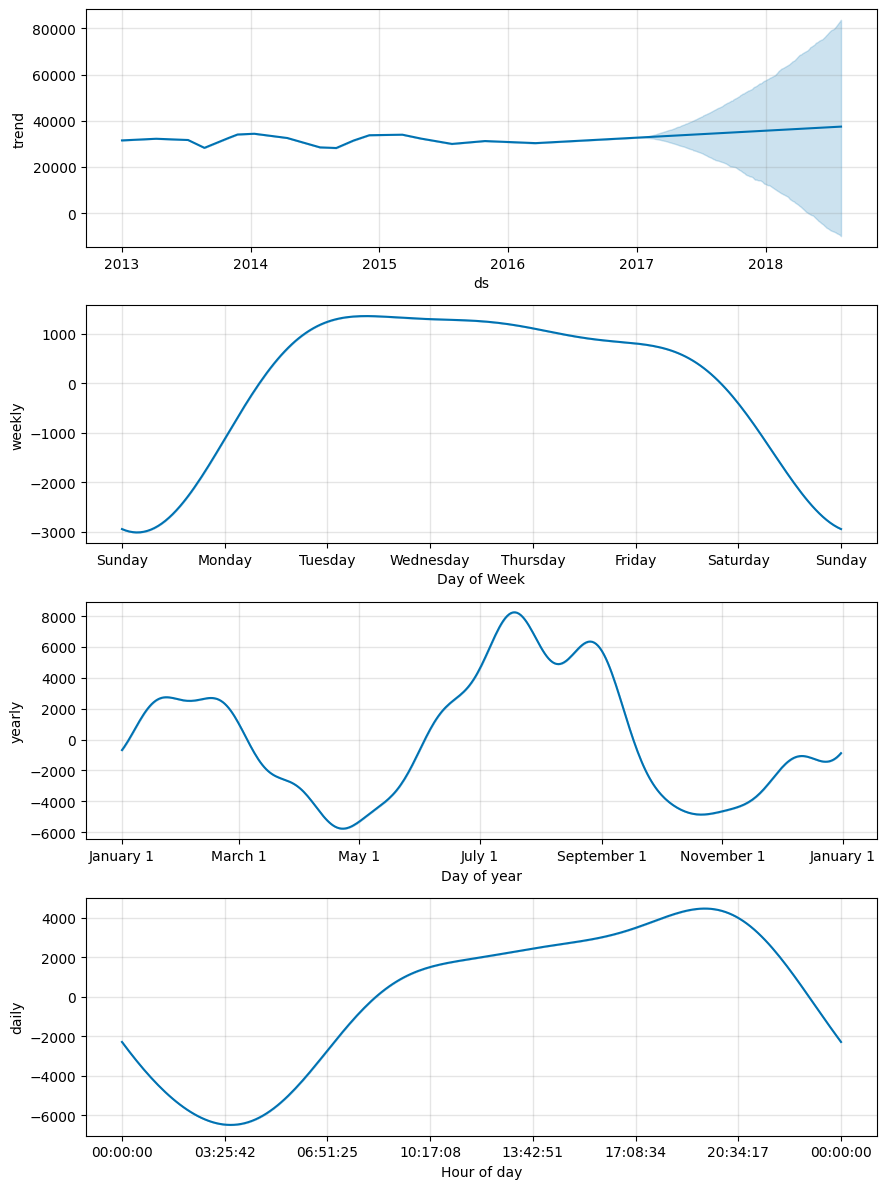

In [29]:
fig = model.plot_components(train_test_forecast);

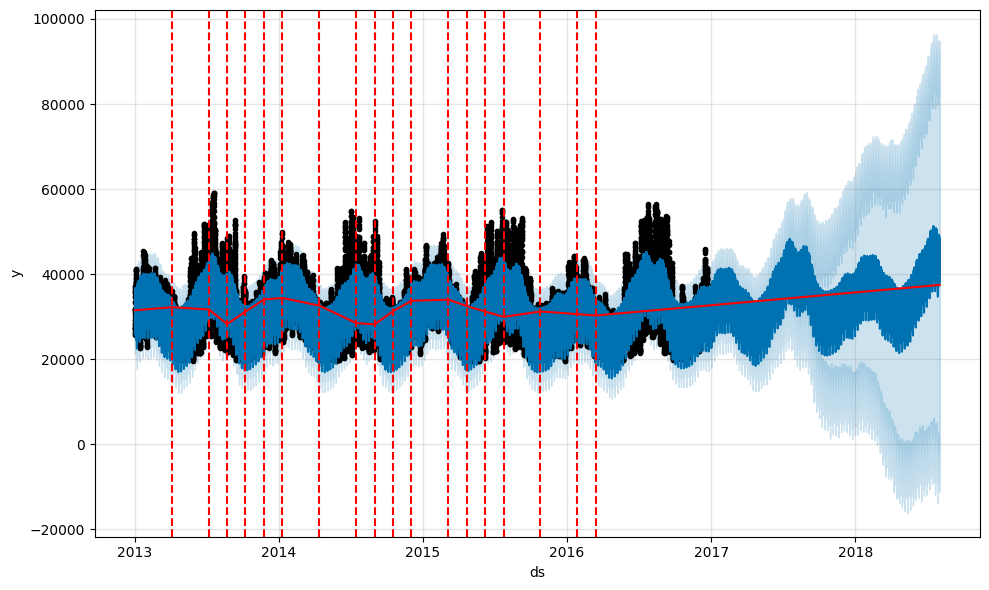

In [30]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(train_test_forecast);
add_changepoints_to_plot(fig.gca(), model, train_test_forecast);

## CONCLUSIONI

- __DAY feature:__ Energy consumption dipende dalle giornate lavorativi e dai week-end
- __HOLIDAY feature:__ Le vacanze modificano l'energy consumption (meno gente lavora)
- __SEASON feature:__ Ci sono 4 picchi stagionali




